In [4]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import img_to_array

from keras import backend as K

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%cd /content/gdrive/MyDrive/Colab Notebooks/
from pathlib import Path





/content/gdrive/MyDrive/Colab Notebooks


In [7]:
EPOCHS = 35
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((100,100))
image_size = 0
directory_root = 'Root/'
width=100
height=100
depth=3

In [8]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [10]:
import os

image_list, label_list = [], []

try:
    print("[INFO] Loading images ...")
    # List all directories in the root directory
    root_dir = [d for d in os.listdir(directory_root) if d != ".DS_Store"]

    for plant_folder in root_dir:
        # List all directories inside each plant folder
        medicinal_plant_list = [d for d in os.listdir(os.path.join(directory_root, plant_folder)) if d != ".DS_Store"]

        for medicinal_plant_folder in medicinal_plant_list:
            print(f"[INFO] Processing {medicinal_plant_folder} ...")
            # List all images in the current medicinal plant folder
            medicinal_plant_image_list = [f for f in os.listdir(os.path.join(directory_root, plant_folder, medicinal_plant_folder)) if f != ".DS_Store"]

            # Process only the first 250 images
            for image in medicinal_plant_image_list[:250]:
                image_directory = os.path.join(directory_root, plant_folder, medicinal_plant_folder, image)

                # Check if the file is a valid image
                if image.lower().endswith(('.jpg', '.jpeg')):
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(medicinal_plant_folder)

    print("[INFO] Image loading completed")

except Exception as e:
    print(f"Error: {e}")


[INFO] Loading images ...
[INFO] Processing Aloevera-Aloe barbadensis ...
[INFO] Processing Amaranthus Green_Amaranthus viridis ...
[INFO] Processing Amaranthus Red_Amaranthus tricolor ...
[INFO] Processing Amla-Phyllanthus emlica Linn ...
[INFO] Processing Amruta Balli-Tinospora cordifolia ...
[INFO] Processing Arali-Nerium oleander ...
[INFO] Processing Arive_Dantu_Amaranthus viridis ...
[INFO] Processing Ashoka-Saraca asoca ...
[INFO] Processing Ashwagandha_Withania somnifera ...
[INFO] Processing Asthma plant_Euphorbia hirta ...
[INFO] Processing Astma_weed ...
[INFO] Processing Avacado_Persea americana ...
[INFO] Processing Avaram_Senna auriculata ...
[INFO] Processing Badipala ...
[INFO] Processing Balloon vine_Cardiospermum halicacabum ...
[INFO] Processing Bamboo-Bambusoideae ...
[INFO] Processing Basale_Basella alba ...
[INFO] Processing Beans-Vigna spp. (Genus) or Phaseolus spp. (Genus) ...
[INFO] Processing Bellyache bush (Green)_Jatropha gossypiifolia ...
[INFO] Processing 

In [11]:
image_size = len(image_list)

In [12]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [13]:
print(label_binarizer.classes_)

['Aloevera-Aloe barbadensis' 'Amaranthus Green_Amaranthus viridis'
 'Amaranthus Red_Amaranthus tricolor' 'Amla-Phyllanthus emlica Linn'
 'Amruta Balli-Tinospora cordifolia' 'Arali-Nerium oleander'
 'Arive_Dantu_Amaranthus viridis' 'Ashoka-Saraca asoca'
 'Ashwagandha_Withania somnifera' 'Asthma plant_Euphorbia hirta'
 'Astma_weed' 'Avacado_Persea americana' 'Avaram_Senna auriculata'
 'Badipala' 'Balloon vine_Cardiospermum halicacabum' 'Bamboo-Bambusoideae'
 'Basale_Basella alba'
 'Beans-Vigna spp. (Genus) or Phaseolus spp. (Genus)'
 'Bellyache bush (Green)_Jatropha gossypiifolia'
 'Benghal dayflower_ Commelina benghalensis' 'Betel-Piper betle'
 'Betel_Nut_Areca catechu' 'Big Caltrops_Tribulus terrestris'
 'Black-Honey Shrub_Tribulus terrestris' 'Brahmi-Bacopa monnieri'
 'Bringaraja-Eclipta prostrata' 'Bristly Wild Grape_Cissus quadrangularis'
 'Butterfly Pea_Clitoria ternatea' 'Camphor-Cinnamomum camphora'
 'Cape Gooseberry_Physalis peruviana' 'Cardiospermum halicacabum'
 'Caricature' '

In [14]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [15]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [16]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2,horizontal_flip=True,
    fill_mode="nearest")

In [17]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 33, 33, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 33, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 33, 33, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 33, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 33, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 33, 33, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 33, 33, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 33, 33, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 33, 33, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 8,765,686 (33.44 MB)

 Trainable params: 8,762,678 (33.43 MB)

 Non-trainable params: 3,008 (11.75 KB)

In [19]:
# Compile the model
opt = Adam(learning_rate=INIT_LR)

model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [20]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 48s 184ms/step - accuracy: 0.0383 - loss: 0.6189 - val_accuracy: 0.0512 - val_loss: 0.1309
Epoch 2/35
  1/175 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0938 - loss: 0.0900

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0938 - loss: 0.0900 - val_accuracy: 0.0512 - val_loss: 0.1287
Epoch 3/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 59s 105ms/step - accuracy: 0.1826 - loss: 0.0835 - val_accuracy: 0.0597 - val_loss: 0.1630
Epoch 4/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3125 - loss: 0.0682 - val_accuracy: 0.0597 - val_loss: 0.1596
Epoch 5/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.3209 - loss: 0.0682 - val_accuracy: 0.2189 - val_loss: 0.1039
Epoch 6/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 0.0658 - val_accuracy: 0.2189 - val_loss: 0.1100
Epoch 7/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.3980 - loss: 0.0609 - val_accuracy: 0.2651 - val_loss: 0.0796
Epoch 8/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 0.0543 - val_accuracy: 0.2743 - val_loss: 0.0786
Epoch 9/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.4478 - loss: 0.0552 - val_accuracy: 0

In [21]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6997 - loss: 0.0342
Test Accuracy: 70.00710964202881


In [23]:
import numpy as np

# Make predictions on the test set
y_pred = model.predict(x_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)


44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


In [24]:
from sklearn.metrics import confusion_matrix

# Convert test labels to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)


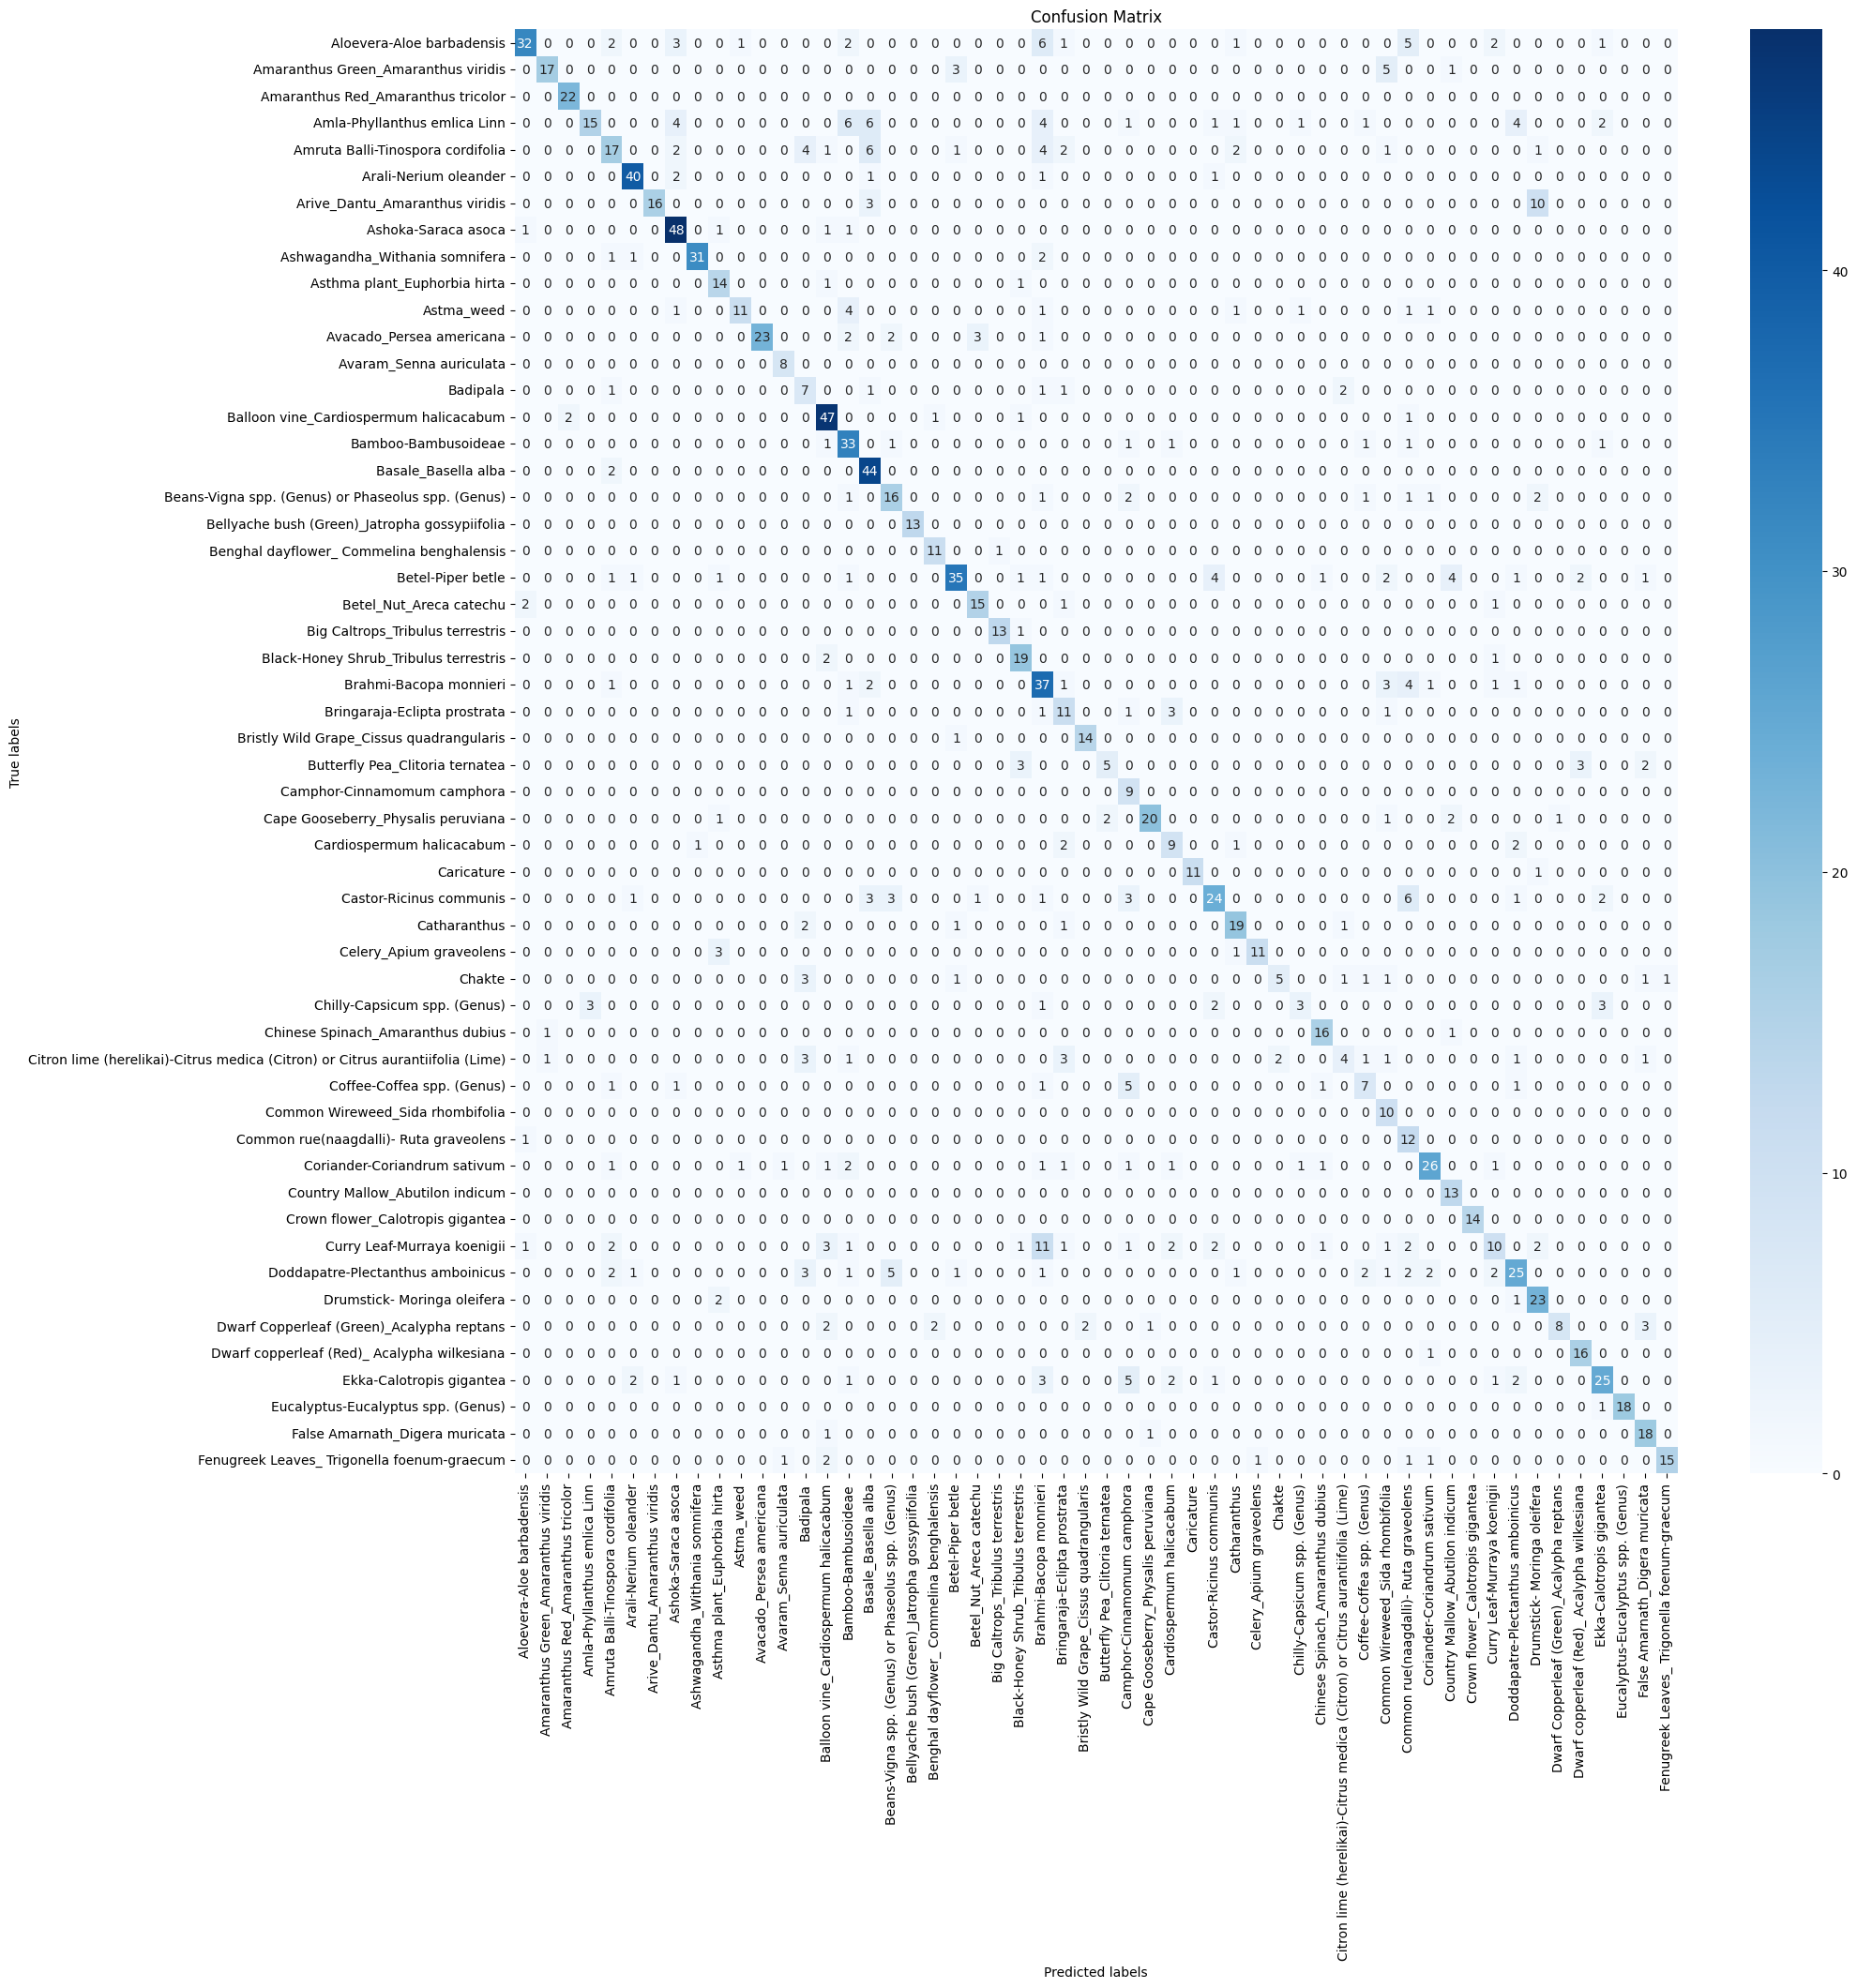

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_binarizer.classes_,  # Adjust these labels to match your classes
            yticklabels=label_binarizer.classes_)  # Adjust these labels to match your classes

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [29]:
model.save('my_model.h5')

In [61]:
scores = model.evaluate(x_train, y_train)
print(f"Test Accuracy for CNN: {scores[1]*100}")

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7603 - loss: 0.0267
Test Accuracy for CNN: 76.14646553993225


In [34]:
# prompt: load mobilenet model

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input

# Define the input shape
input_tensor = Input(shape=(height, width, depth))

# Load the pre-trained MobileNetV2 model (excluding the top classification layer)
base_model = MobileNetV2(
    input_tensor=input_tensor,
    weights='imagenet',
    include_top=False
)
base_model.summary()

<ipython-input-34-984f176cd361>:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 50, 50, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 50, 50, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 50, 50, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 50, 50, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 50, 50, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 50, 50, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 50, 50, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 50, 50, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 50, 50, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 50, 50, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 50, 50, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 51, 51, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 25, 25, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [44]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Dense layer with ReLU activation
predictions = Dense(len(label_binarizer.classes_), activation='softmax')(x)  # Final classification layer

# Create the final model
model1 = Model(inputs=base_model.input, outputs=predictions)

# Print the summary of the complete model
model1.summary()


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 50, 50, 32)     │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 50, 50, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 50, 50, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 50, 50, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 50, 50, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 50, 50, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 50, 50, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 50, 50, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 50, 50, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 50, 50, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 50, 50, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 51, 51, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 25, 25, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 3,625,078 (13.83 MB)

 Trainable params: 1,367,094 (5.22 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model1.compile(
    optimizer=Adam(learning_rate=1e-5),  # Use learning rate scheduler if needed
    loss='categorical_crossentropy',  # Or 'binary_crossentropy' for binary classification
    metrics=['accuracy']
)


In [47]:
history = model1.fit(
     aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1

)


Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 37s 168ms/step - accuracy: 0.0505 - loss: 4.2358 - val_accuracy: 0.2445 - val_loss: 3.1850
Epoch 2/35
  1/175 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1875 - loss: 3.3567

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1875 - loss: 3.3567 - val_accuracy: 0.2466 - val_loss: 3.1788
Epoch 3/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.3536 - loss: 2.8486 - val_accuracy: 0.4705 - val_loss: 2.3524
Epoch 4/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5625 - loss: 2.3721 - val_accuracy: 0.4719 - val_loss: 2.3484
Epoch 5/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.5733 - loss: 2.0777 - val_accuracy: 0.5835 - val_loss: 1.8368
Epoch 6/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7188 - loss: 1.7531 - val_accuracy: 0.5842 - val_loss: 1.8341
Epoch 7/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.6971 - loss: 1.5785 - val_accuracy: 0.6610 - val_loss: 1.4990
Epoch 8/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 1.4838 - val_accuracy: 0.6603 - val_loss: 1.4979
Epoch 9/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 117ms/step - accuracy: 0.7564 - loss: 1.2551 - val_accuracy: 0

In [48]:
print("[INFO] Calculating model accuracy")
scores = model1.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8039 - loss: 0.6815
Test Accuracy: 81.09452724456787


In [50]:
y_pred1 = model1.predict(x_test)

# Convert predictions to class labels
y_pred_classes1 = np.argmax(y_pred1, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [54]:
from sklearn.metrics import confusion_matrix

# Convert test labels to class labels
y_test_classes1 = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm1 = confusion_matrix(y_test_classes1, y_pred_classes1)

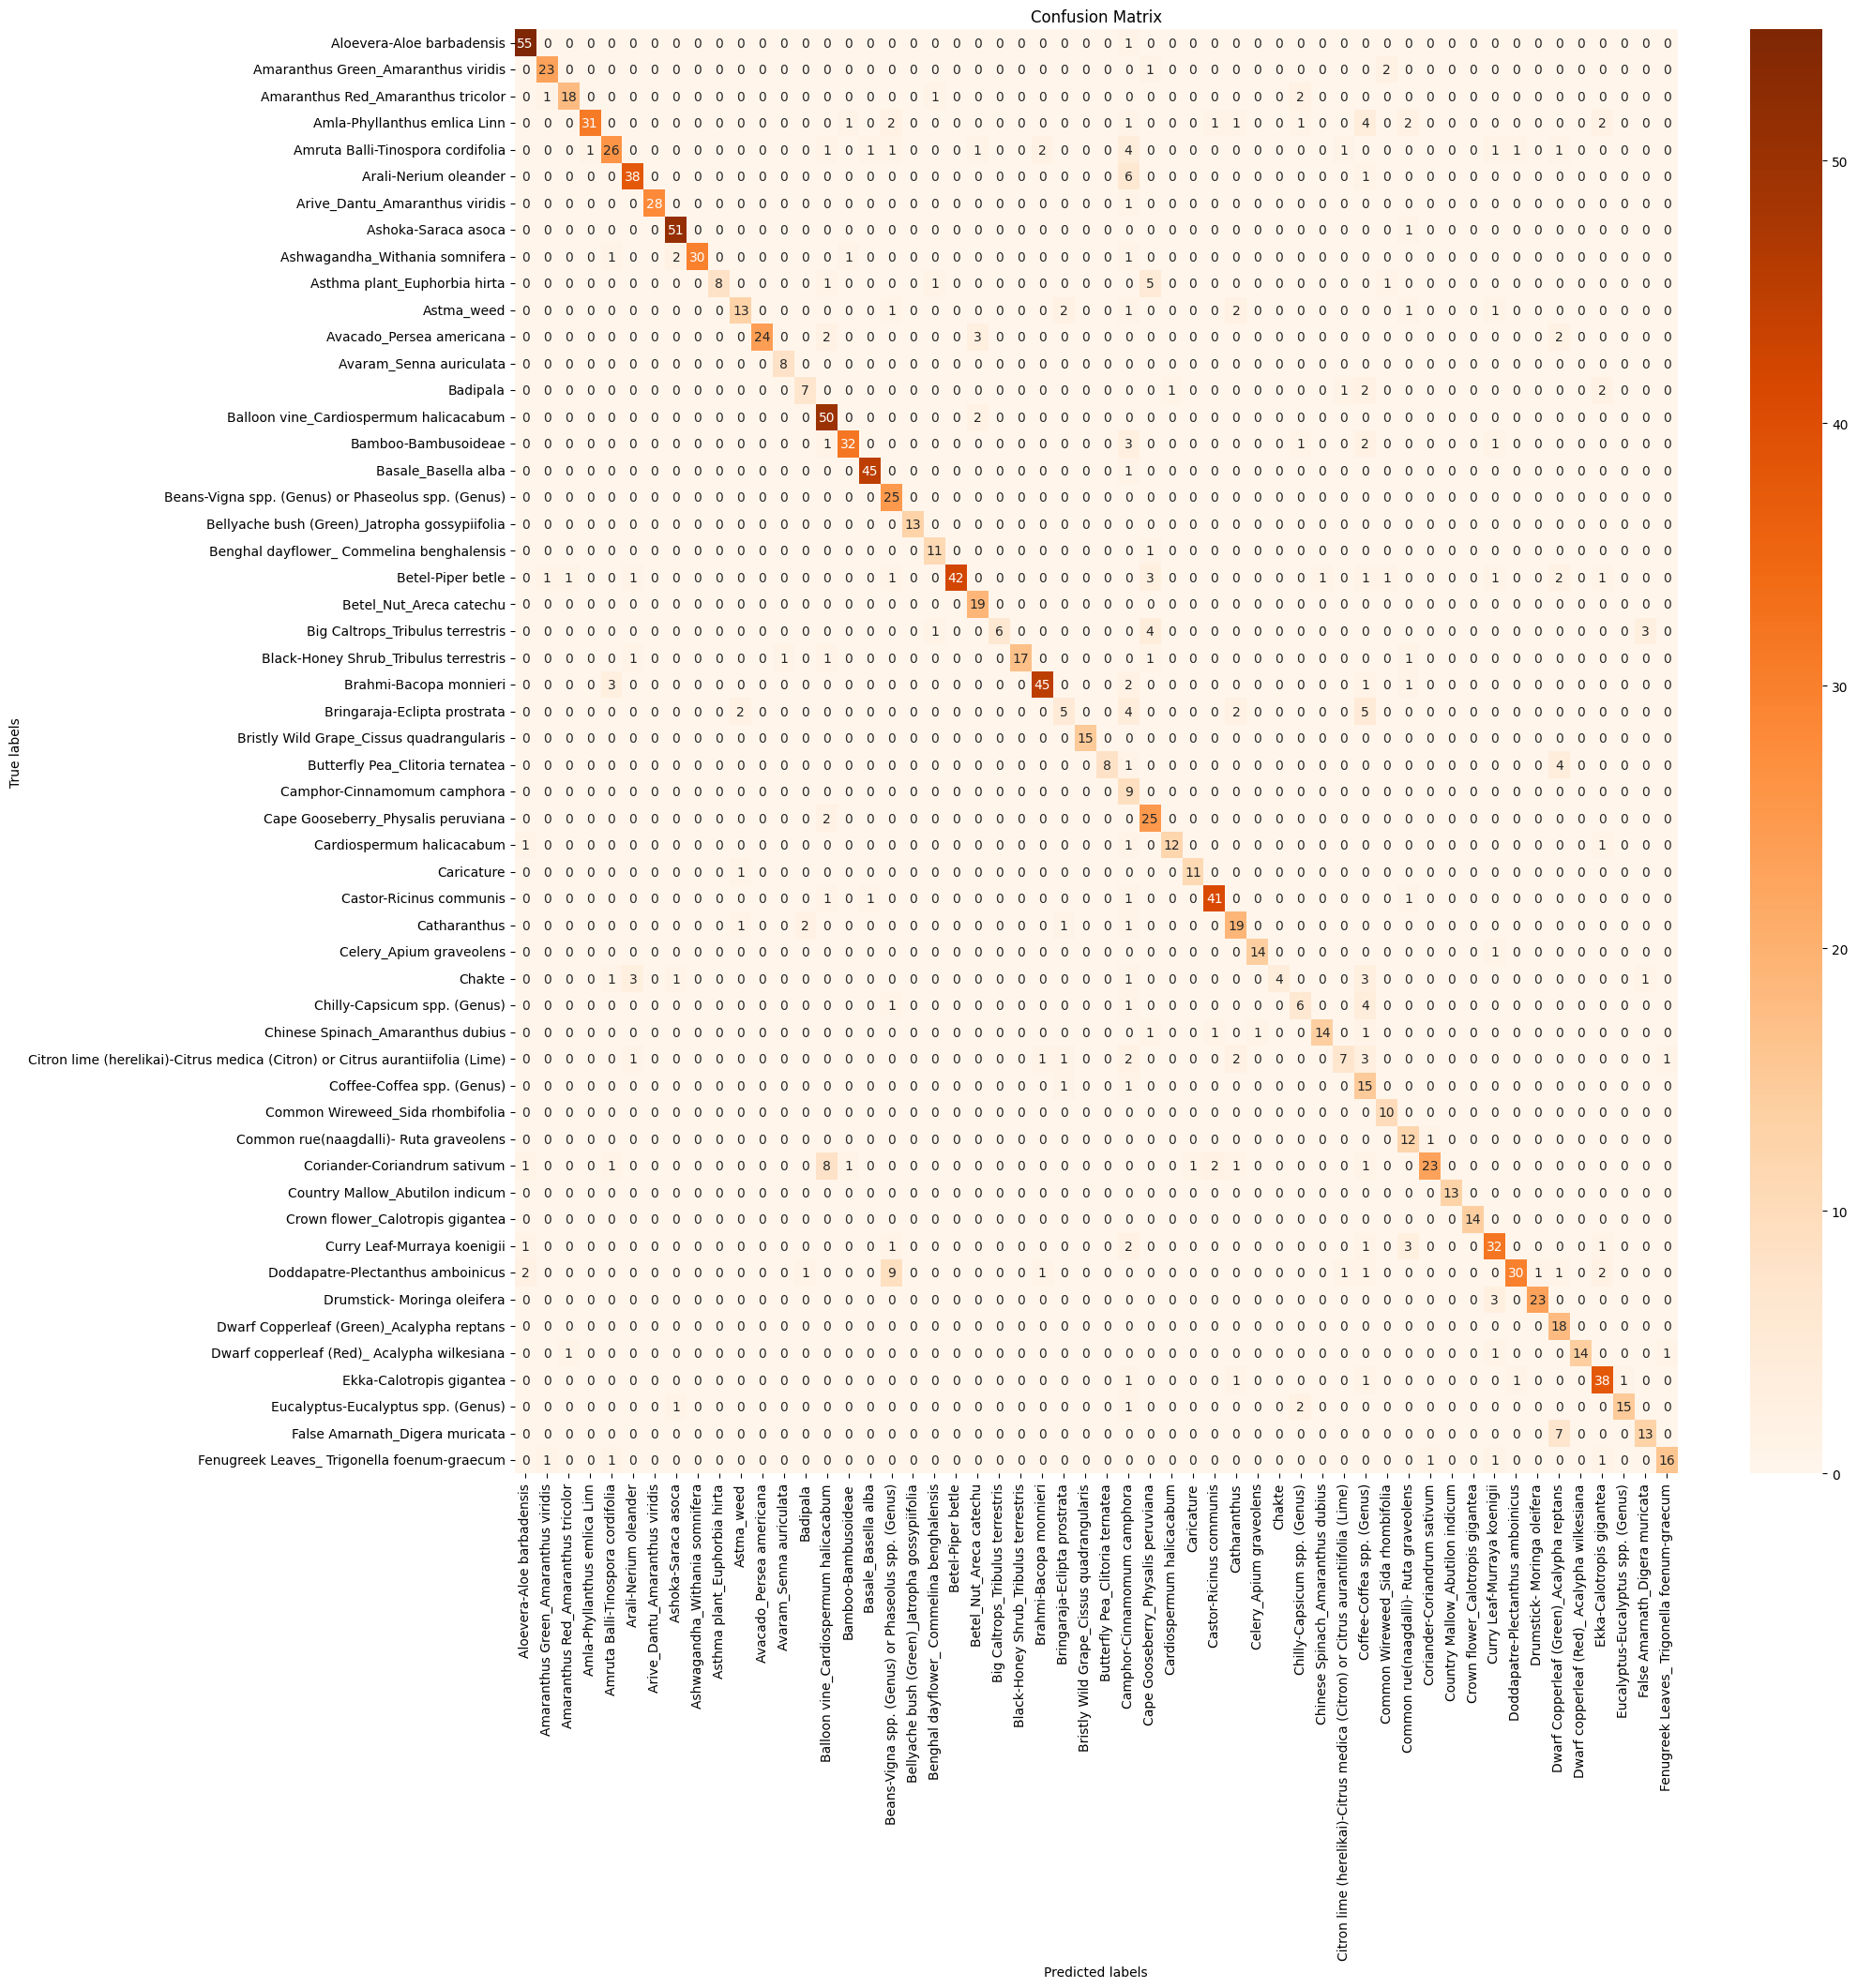

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_binarizer.classes_,  # Adjust these labels to match your classes
            yticklabels=label_binarizer.classes_)  # Adjust these labels to match your classes

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [56]:
model.save('my_model_MobileNetV2.h5')

In [60]:
scores1 = model1.evaluate(x_train, y_train)
print(f"Test Accuracy for MobileNetV2: {scores1[1]*100}")

176/176 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8652 - loss: 0.4711
Test Accuracy for MobileNetV2: 85.94027757644653


In [63]:
from tensorflow.keras.applications import ResNet50
base_model2 = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 106, 106, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 25, 25, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 25, 25, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 25, 25, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [64]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
for layer in base_model2.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = Dense(1024, activation='relu')(x)  # Dense layer with ReLU activation
predictions = Dense(len(label_binarizer.classes_), activation='softmax')(x)  # Final classification layer

# Create the final model
model2 = Model(inputs=base_model2.input, outputs=predictions)

# Print the summary of the complete model
model2.summary()


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 106, 106, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 25, 25, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 25, 25, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 25, 25, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,741,238 (98.20 MB)

 Trainable params: 25,688,118 (97.99 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [65]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model2.compile(
    optimizer=Adam(learning_rate=1e-5),  # Use learning rate scheduler if needed
    loss='categorical_crossentropy',  # Or 'binary_crossentropy' for binary classification
    metrics=['accuracy']
)


In [66]:
history = model2.fit(
     aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    verbose=1

)


Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 125s 343ms/step - accuracy: 0.0745 - loss: 3.9908 - val_accuracy: 0.0370 - val_loss: 30.6354
Epoch 2/35
  1/175 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.1875 - loss: 3.2133

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1875 - loss: 3.2133 - val_accuracy: 0.0370 - val_loss: 30.1353
Epoch 3/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 28s 153ms/step - accuracy: 0.3860 - loss: 2.5893 - val_accuracy: 0.0362 - val_loss: 55.8483
Epoch 4/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5625 - loss: 1.9569 - val_accuracy: 0.0355 - val_loss: 55.5847
Epoch 5/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 39s 151ms/step - accuracy: 0.5861 - loss: 1.7705 - val_accuracy: 0.0299 - val_loss: 22.8395
Epoch 6/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7812 - loss: 1.1812 - val_accuracy: 0.0320 - val_loss: 22.5988
Epoch 7/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 39s 150ms/step - accuracy: 0.7303 - loss: 1.2010 - val_accuracy: 0.1073 - val_loss: 6.5108
Epoch 8/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8438 - loss: 0.8150 - val_accuracy: 0.1080 - val_loss: 6.5273
Epoch 9/35
175/175 ━━━━━━━━━━━━━━━━━━━━ 26s 148ms/step - accuracy: 0.7943 - loss: 0.8854 - val_accura

In [67]:
print("[INFO] Calculating model accuracy")
scores = model2.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9289 - loss: 0.3330
Test Accuracy: 93.24804544448853


In [68]:

# Make predictions on the test set
y_pred2 = model2.predict(x_test)

# Convert predictions to class labels
y_pred_classes2 = np.argmax(y_pred2, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step


In [70]:
from sklearn.metrics import confusion_matrix

# Convert test labels to class labels
y_test_classes2 = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm2= confusion_matrix(y_test_classes2, y_pred_classes2)


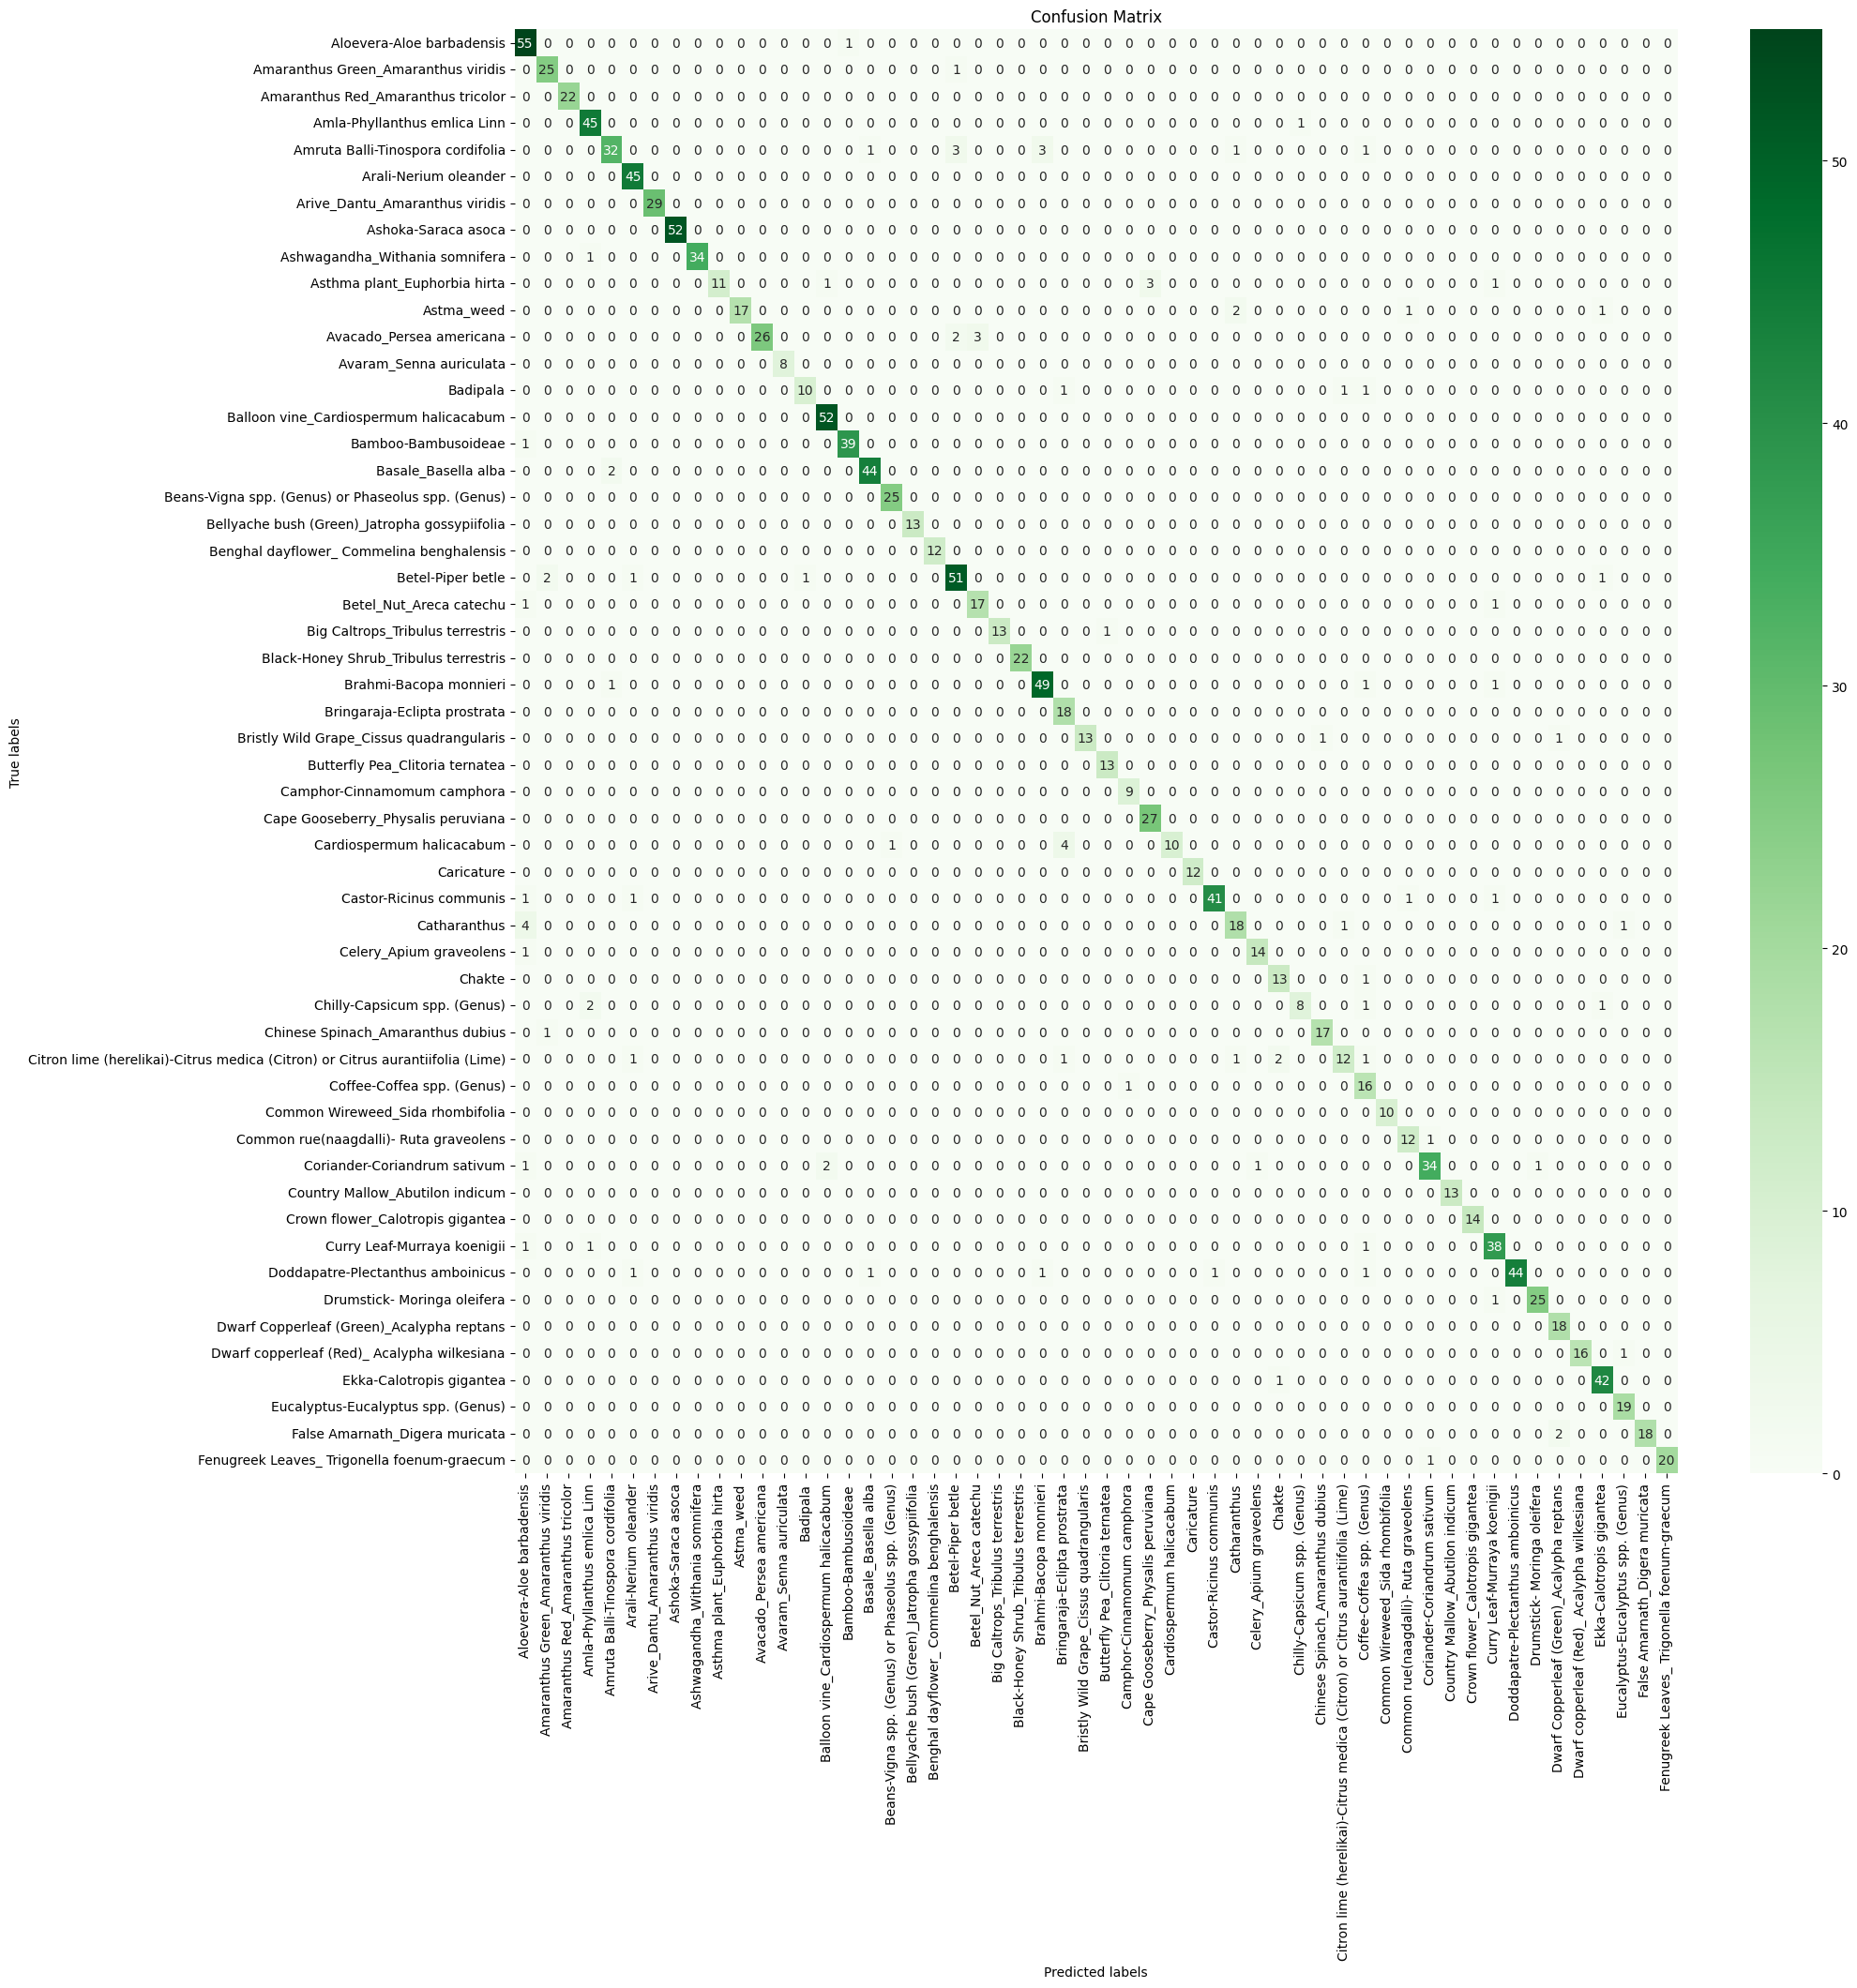

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_binarizer.classes_,  # Adjust these labels to match your classes
            yticklabels=label_binarizer.classes_)  # Adjust these labels to match your classes

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [75]:
model.save('my_model_ResNet.h5')

In [76]:
scores2 = model2.evaluate(x_train, y_train)
print(f"Test Accuracy for MobileNetV2: {scores2[1]*100}")
#The best accuracy for this dataset till now .........

176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.9894 - loss: 0.0404
Test Accuracy for MobileNetV2: 98.79132509231567


In [80]:
import time
start_time = time.time()
model.predict(x_test[:10])
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time for CNN: {inference_time} seconds")
start_time1= time.time()
model1.predict(x_test[:10])
end_time1 = time.time()
inference_time = end_time1 - start_time1
print(f"Inference Time for MobileNetV2: {inference_time} seconds")
start_time2 = time.time()
model2.predict(x_test[:10])
end_time2 = time.time()
inference_time = end_time2 - start_time2
print(f"Inference Time ResNet: {inference_time} seconds")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Inference Time for CNN: 0.11054849624633789 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Inference Time for MobileNetV2: 0.10885906219482422 seconds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Inference Time ResNet: 0.14517807960510254 seconds
